In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import transforms

In [2]:
batch_size = 1024

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)
dataset = MNIST(root="data/", download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    drop_last=True,
)

test_dataset = MNIST(root="data/", train=False, transform=transform)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, num_workers=4, pin_memory=True
)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)>



100%|██████████| 9912422/9912422 [00:03<00:00, 3180810.90it/s]


Extracting data/MNIST\raw\train-images-idx3-ubyte.gz to data/MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)>



100%|██████████| 28881/28881 [00:00<00:00, 132245.51it/s]


Extracting data/MNIST\raw\train-labels-idx1-ubyte.gz to data/MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)>



100%|██████████| 1648877/1648877 [00:01<00:00, 1385423.77it/s]


Extracting data/MNIST\raw\t10k-images-idx3-ubyte.gz to data/MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)>



100%|██████████| 4542/4542 [00:00<00:00, 2270623.21it/s]

Extracting data/MNIST\raw\t10k-labels-idx1-ubyte.gz to data/MNIST\raw



In [3]:
class FlatModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        return x

In [4]:
class DenseModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.stack(x)
        return x

In [5]:
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=2, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=2, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(4096, 1024),
            nn.ReLU(),
            nn.Linear(1024, 10),
        )

    def forward(self, xb):
        out = self.stack(xb)
        return out

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DenseModel().to(device)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
crit = nn.CrossEntropyLoss()

test_losses = []
losses = []

def test():
    with torch.no_grad():
        test_loss = 0
        for i, (images, labels) in enumerate(test_dataloader):
            out = model(images.to(device))
            test_loss += F.cross_entropy(out, labels.to(device), reduction='sum').item()  
        test_loss /= len(test_dataset)

    return test_loss

epochs = 6
def train(epochs):
    for epoch in range(epochs):
        for i, (images, labels) in enumerate(dataloader):
            out = model(images.to(device))
            loss = crit(out, labels.to(device))
            loss.backward()
            optim.step()
            optim.zero_grad()

            if i % 10 == 0:
                losses.append(loss.item())
                test_losses.append(test())
        
        print(f'Epoch: {epoch}, Loss: {loss.item()}')
train(epochs)

Epoch: 0, Loss: 0.2851570248603821
Epoch: 1, Loss: 0.27231064438819885
Epoch: 2, Loss: 0.1551106870174408
Epoch: 3, Loss: 0.1260196417570114
Epoch: 4, Loss: 0.10962289571762085
Epoch: 5, Loss: 0.09384678304195404


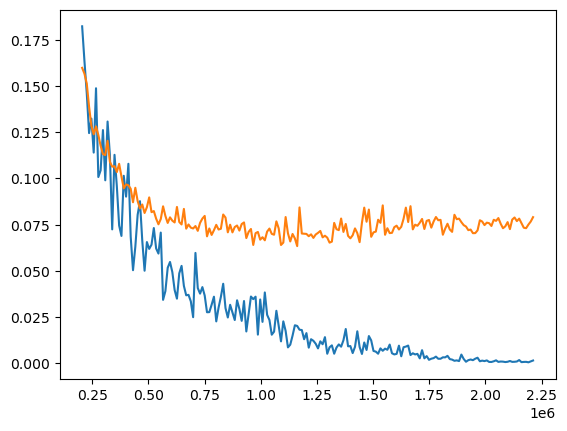

In [18]:
import matplotlib.pyplot as plt
import numpy as np

o = 20
d = len(losses)

plt.plot(np.linspace(o*10*1024, d*10*1024, d-o),losses[o:d])
plt.plot(np.linspace(o*10*1024, d*10*1024, d-o),test_losses[o:d])

In [8]:
train(30)

Epoch: 0, Loss: 0.08212020993232727
Epoch: 1, Loss: 0.11051765829324722
Epoch: 2, Loss: 0.052017077803611755
Epoch: 3, Loss: 0.04291161522269249
Epoch: 4, Loss: 0.04474470019340515
Epoch: 5, Loss: 0.057223767042160034
Epoch: 6, Loss: 0.06287599354982376
Epoch: 7, Loss: 0.031081808730959892
Epoch: 8, Loss: 0.04861593618988991
Epoch: 9, Loss: 0.021587884053587914
Epoch: 10, Loss: 0.023029476404190063
Epoch: 11, Loss: 0.017413873225450516
Epoch: 12, Loss: 0.012582981958985329
Epoch: 13, Loss: 0.01295454241335392
Epoch: 14, Loss: 0.01338584627956152
Epoch: 15, Loss: 0.007225676439702511
Epoch: 16, Loss: 0.015509840101003647
Epoch: 17, Loss: 0.011892658658325672
Epoch: 18, Loss: 0.005078874062746763
Epoch: 19, Loss: 0.010884447023272514
Epoch: 20, Loss: 0.005335474386811256
Epoch: 21, Loss: 0.003885129699483514
Epoch: 22, Loss: 0.007143693044781685
Epoch: 23, Loss: 0.0030329013243317604
Epoch: 24, Loss: 0.0019333244999870658
Epoch: 25, Loss: 0.00356524670496583
Epoch: 26, Loss: 0.0011216043

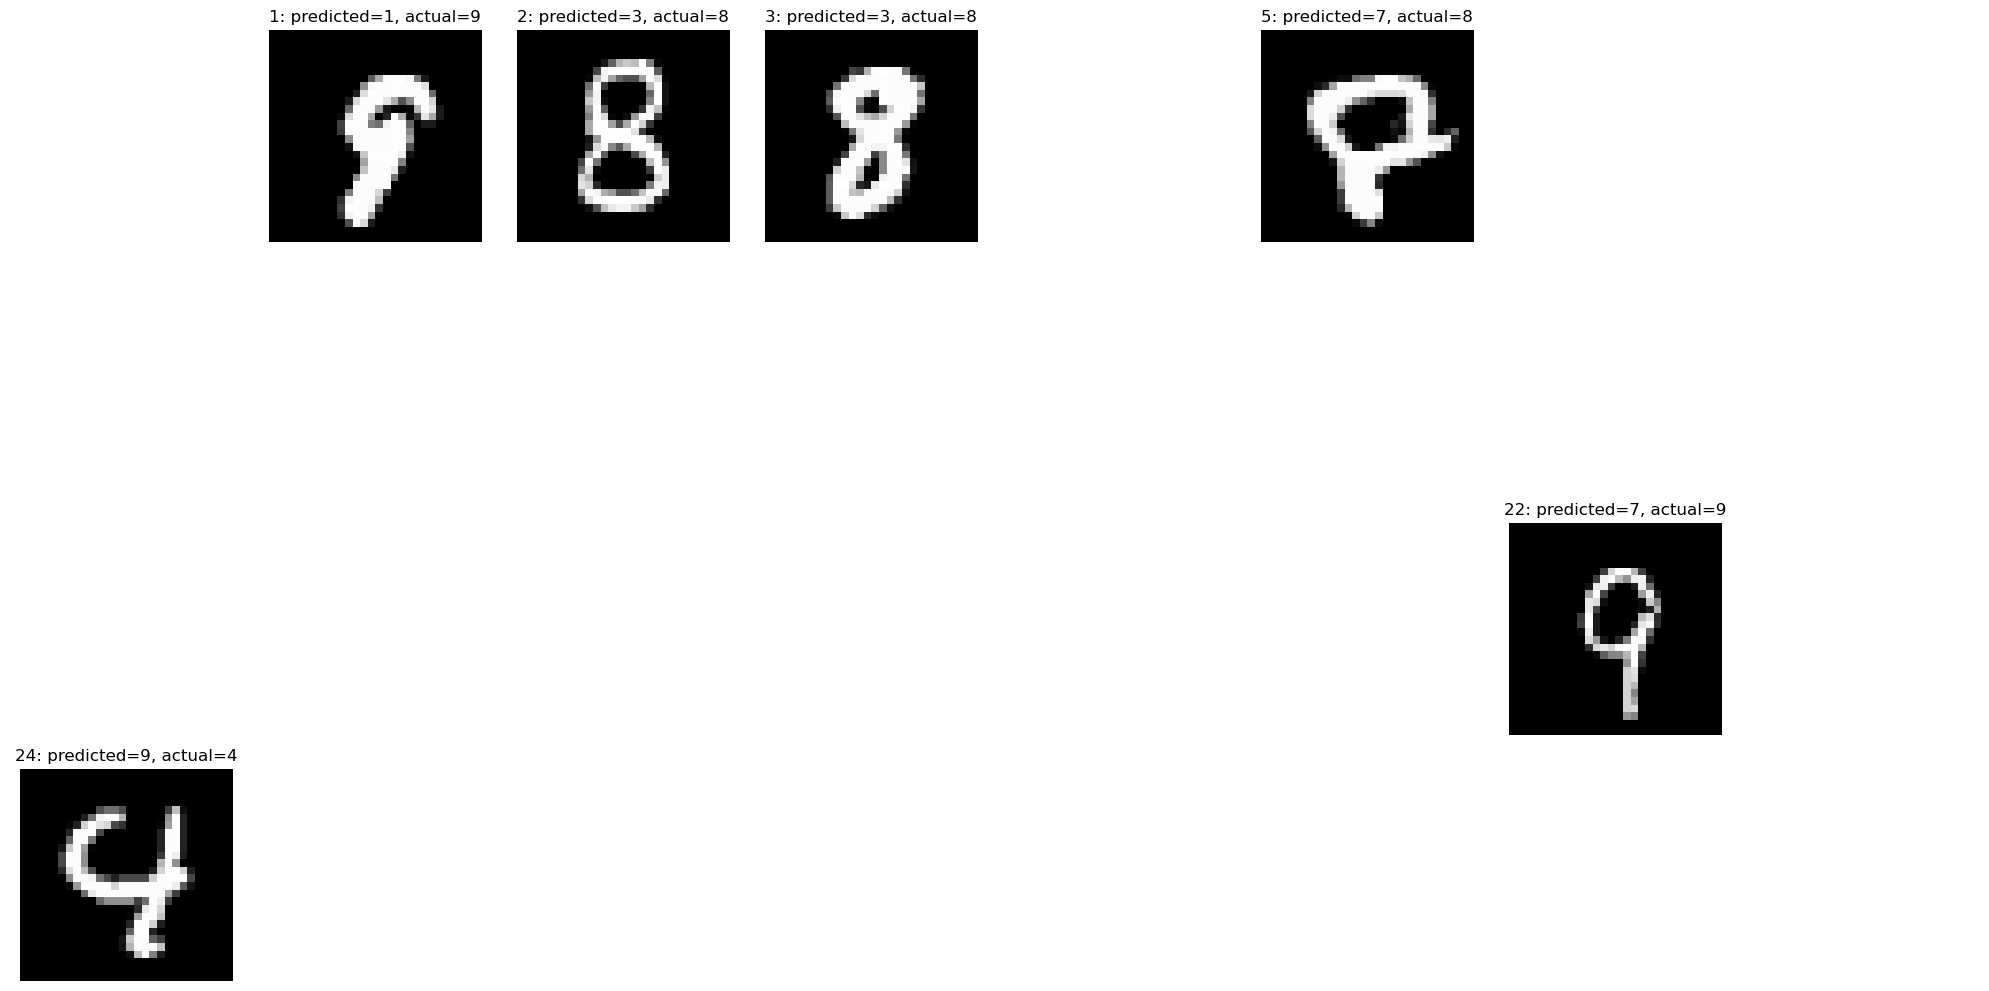

In [19]:
fig, axs = plt.subplots(4, 8, figsize=(20, 10))
axs = axs.flatten()

k = 1234

images = dataset.data[k:32+k].float().unsqueeze(1)
labels = dataset.targets[k:32+k]

with torch.no_grad():
    out = model(images.to(device))

for i in range(32):
    predicted = out[i].argmax().item()
    actual = labels[i].item()
    if predicted != actual:
        axs[i].imshow(images[i].reshape(28, 28), cmap='gray')
        axs[i].set_title(f'{i}: {predicted=}, {actual=}')
    axs[i].axis('off')

plt.tight_layout()
plt.show()

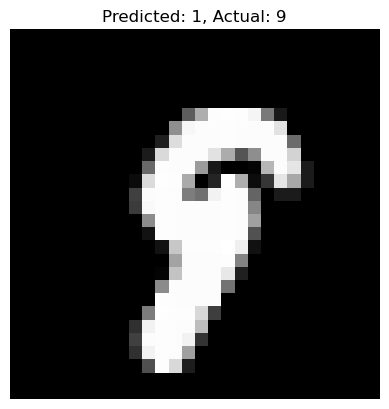

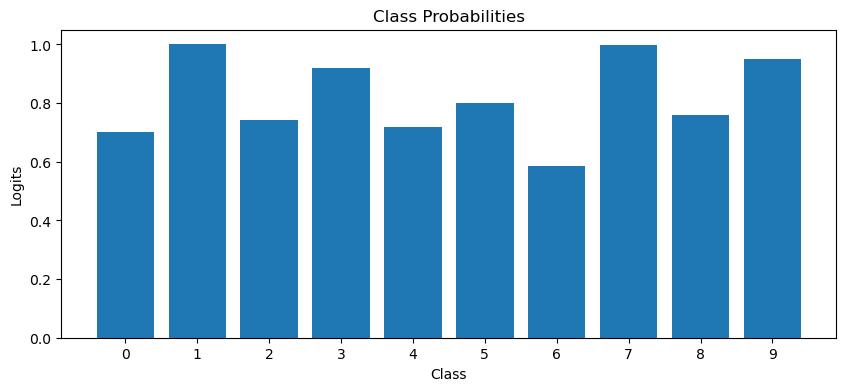

In [20]:
i = 1
with torch.no_grad():
    logits = model(images[i].unsqueeze(0).to(device))
plt.imshow(images[i].reshape(28, 28), cmap='gray')
plt.title(f'Predicted: {logits.argmax().item()}, Actual: {labels[i]}')
plt.axis('off')

reduce = True

c = 1/logits.sum() if reduce else 1
probabilities = ((logits.max()-logits)*c).exp().squeeze()
plt.figure(figsize=(10, 4))
plt.bar(range(10), probabilities.cpu().numpy())
plt.xticks(range(10))
plt.xlabel('Class')
plt.ylabel('Logits')
plt.title('Class Probabilities')
plt.show()